In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_pth = r'/Users/ahmadfaiz/Documents/edge_llmc/'
int8_agx30_pth = os.path.join(base_pth, "int8_trt", "int8_agx64g_30W", "logs2")
int8_agx50_pth = os.path.join(base_pth, "int8_trt", "int8_agx64g_50W", "logs2")
int8_agx15_pth = os.path.join(base_pth, "int8_trt", "int8_agx64g_15W", "logs_15W")
fp32_agx30_pth = os.path.join(base_pth, "agx_64g", "logs2", "logs2")
fp32_agx50_pth = os.path.join(base_pth, "agx_64_50W", "logs2")
fp32_agx15_pth = os.path.join(base_pth, "agx64_15W", "agx64_15W", "logs2")
fp32_nano15_pth = os.path.join(base_pth, "nano_8g", "logs_nano_8g")
fp32_cpu30_pth = os.path.join(base_pth, "cpu_agx64", "logs_30W")
fp32_cpu15_pth = os.path.join(base_pth, "cpu_agx64", "logs_15W")
fp32_cpu50_pth = os.path.join(base_pth, "cpu_agx64", "logs_50W")

In [3]:
model_list = ['alexnet', 'squeezenet', 'resnet18', 'resnet50', 'densenet', 'vgg16']
metric_list = ['mem', 'power', 'cpu', 'cpu_temp']
b_size_list = [1,2,4,8,16,32,64,128,256]

## resource metrics
mem_cols = ["hw_name", "model_name", "batch_size", "tot", "used", "free", "buffers", "cached", "shared", "lfb"]
pow_cols = ["hw_name", "model_name", "batch_size", "power", "average_power"]
energy_cols = ["hw_name", "model_name", "batch_size", "energy"]
cpu_cols = ["hw_name", "model_name", "batch_size", "user", "nice", "system", "idle"]
cpu_temp_cols = ["hw_name", "model_name", "batch_size", "temp", "online"]

##batch size filters if required
b_size_filt = [32,64,128]

In [4]:
#data load for throughput readings
def util_prep(model_list, pth_, precision, hw_name, power_mode):
    '''prepare union dataset across all logs for throughput data'''
    util_dict = {mod: {str(b): None for b in b_size_list} for mod in model_list}
    for mod in model_list:
        pth = os.path.join(pth_, mod)
        util_files = [f for f in os.listdir(pth) if f.startswith("util")]
        for u_f in util_files:
            sub = u_f.split("_")
            util_dict[sub[1]][str(sub[2])] = pd.read_csv(os.path.join(pth, u_f))
    util_df = pd.DataFrame()
    for mod in model_list:
        k_ = util_dict[mod].values()
        if any(el_ is not None for el_ in k_):
            mod_util = list(util_dict[mod].values())
            if mod_util:
                mod_util_df = pd.concat(mod_util).reset_index(drop=True)
                mod_util_df = mod_util_df.assign(model_name = mod, precision = precision, hw_name = hw_name)
                util_df = pd.concat([util_df, mod_util_df], ignore_index=True)
    df_grouped = util_df.groupby(["hw_name", "model_name", "precision", "batch_size"])
    #.agg() accepts a list of tuples with operations defined as string
    df_thru = df_grouped["iter_throughput"].agg([("mean_throughput", "mean"), ("std_throughput", "std")]).reset_index()
    df_inf = df_grouped["iter_time"].agg([("mean_time", "mean"), ("std_time", "std")]).reset_index()
    util_df_agg = pd.merge(left=df_thru, right=df_inf, on=["hw_name", "precision", "model_name", "batch_size"], how="inner")    
    util_df_agg["power_mode"] = power_mode
    return util_df_agg

In [5]:
# int8_util_df = pd.DataFrame()
int8agx30_util_df = util_prep(model_list, int8_agx30_pth, "int8", "agx64g", "30W")
int8agx50_util_df = util_prep(model_list, int8_agx50_pth, "int8", "agx64g", "50W")
int8agx15_util_df = util_prep(model_list, int8_agx15_pth, "int8", "agx64g", "15W")
fp32agx30_util_df = util_prep(model_list, fp32_agx30_pth, "fp32", "agx64g", "30W")
fp32agx50_util_df = util_prep(model_list, fp32_agx50_pth, "fp32", "agx64g", "50W")
fp32agx15_util_df = util_prep(model_list, fp32_agx15_pth, "fp32", "agx64g", "15W")
fp32nano15_util_df = util_prep(model_list, fp32_nano15_pth, "fp32", "nano8g", "15W")
fp32cpu30_util_df = util_prep(model_list, fp32_cpu30_pth, "fp32", "cpu", "30W")
fp32cpu15_util_df = util_prep(model_list, fp32_cpu15_pth, "fp32", "cpu", "15W")
fp32cpu50_util_df = util_prep(model_list, fp32_cpu50_pth, "fp32", "cpu", "50W")

In [29]:
def set_vals(df_, precision, hw_name, power_mode):
    df_["precision"] = precision
    df_["hw_name"] = hw_name
    df_["power_mode"] = power_mode
    df_['time'] = df_.groupby(['hw_name', 'model_name', 'batch_size', 'power_mode', 'precision']).cumcount() + 1
    return df_

In [30]:
def res_prep(model_list, b_size_list, metric_list, pth_, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision, hw_name, power_mode):
    '''Prepare union dataset across all logs for each hardware resource metric. Metrics included are
    1. Memory
    2. CPU
    3. Power
    4. CPU Temperature
    '''
    hw_dict = {mod: {met: {str(b): None for b in b_size_list} for met in metric_list} for mod in model_list}
    for mod in model_list:
        pth = os.path.join(pth_, mod)
        files = [f for f in os.listdir(pth) if f.endswith("csv") and not f.startswith("util")]
        for f in files:
            if "temp" not in f:
                sub = f.split('_')            
                hw_dict[sub[1]][sub[0]][str(sub[2])] = pd.read_csv(os.path.join(pth, f))
            else:
                sub = f.split('_')
                hw_dict[sub[2]]["_".join([sub[0], sub[1]])][str(sub[3])] = pd.read_csv(os.path.join(pth, f))

    ## create individual resource metric dataframe
    mem_df = pd.DataFrame(columns=mem_cols)
    pow_df = pd.DataFrame(columns=pow_cols)
    cpu_df = pd.DataFrame(columns=cpu_cols)
    cpu_temp_df = pd.DataFrame(columns=cpu_temp_cols)

    for model_name,v in hw_dict.items():
        for met, v1 in v.items():
            if met == "mem":
                for b_size, v2 in v1.items():
                    if v2 is not None:
                        df_ = pd.DataFrame({
                            "hw_name": "agx",
                            "model_name": model_name,
                            "batch_size": int(b_size),
                            "tot": v2["tot"],
                            "used": v2["used"],
                            "free": v2["free"],
                            "buffers": v2["buffers"],
                            "cached": v2["cached"],
                            "shared": v2["shared"],
                            "lfb": v2["lfb"]
                        })
                        mem_df = pd.concat([mem_df, df_], ignore_index=True)
            if met == "power":
                for b_size, v2 in v1.items():
                    if v2 is not None:
                        df_ = pd.DataFrame({
                            "hw_name": "agx",
                            "model_name": model_name,
                            "batch_size": int(b_size),
                            "power": v2["power"],
                            "average_power": v2["average_power"]
                        })
                        pow_df = pd.concat([pow_df, df_], ignore_index=True) 
            if met == "cpu":
                for b_size, v2 in v1.items():
                    if v2 is not None:
                        df_ = pd.DataFrame({
                            "hw_name": "agx",
                            "model_name": model_name,
                            "batch_size": int(b_size),
                            "user": v2["user"],
                            "nice": v2["nice"],
                            "system": v2["system"],
                            "idle": v2["idle"],
                        })
                        cpu_df = pd.concat([cpu_df, df_], ignore_index=True)
            if met == "cpu_temp":
                for b_size, v2 in v1.items():
                    if v2 is not None:
                        df_ = pd.DataFrame({
                            "hw_name": "agx",
                            "model_name": model_name,
                            "batch_size": int(b_size),
                            "temp": v2["temp"],
                            "online": v2["online"]
                        })
                        cpu_temp_df = pd.concat([cpu_temp_df, df_], ignore_index=True)

    mem_df["used_rate"] = mem_df["used"]/mem_df["tot"]
    cpu_df["user_system"] = cpu_df["user"] + cpu_df["system"]

    mem_df = set_vals(mem_df, precision, hw_name, power_mode)
    cpu_df = set_vals(cpu_df, precision, hw_name, power_mode)
    pow_df = set_vals(pow_df, precision, hw_name, power_mode)
    cpu_temp_df = set_vals(cpu_temp_df, precision, hw_name, power_mode)

    return mem_df, pow_df, cpu_df, cpu_temp_df

In [31]:
mem_int8agx30, pow_int8agx30, cpu_int8agx30, cpu_temp_int8agx30 = res_prep(model_list, b_size_list, metric_list, int8_agx30_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="int8", hw_name="agx64g", power_mode="30W")
mem_int8agx50, pow_int8agx50, cpu_int8agx50, cpu_temp_int8agx50 = res_prep(model_list, b_size_list, metric_list, int8_agx50_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="int8", hw_name="agx64g", power_mode="50W")
mem_int8agx15, pow_int8agx15, cpu_int8agx15, cpu_temp_int8agx15 = res_prep(model_list, b_size_list, metric_list, int8_agx15_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="int8", hw_name="agx64g", power_mode="15W")

mem_fp32agx30, pow_fp32agx30, cpu_fp32agx30, cpu_temp_fp32agx30 = res_prep(model_list, b_size_list, metric_list, fp32_agx30_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="agx64g", power_mode="30W")
mem_fp32agx50, pow_fp32agx50, cpu_fp32agx50, cpu_temp_fp32agx50 = res_prep(model_list, b_size_list, metric_list, fp32_agx50_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="agx64g", power_mode="50W")
mem_fp32agx15, pow_fp32agx15, cpu_fp32agx15, cpu_temp_fp32agx15 = res_prep(model_list, b_size_list, metric_list, fp32_agx15_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="agx64g", power_mode="15W")

mem_fp32nano15, pow_fp32nano15, cpu_fp32nano15, cpu_temp_fp32nano15 = res_prep(model_list, b_size_list, metric_list, fp32_nano15_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="nano8g", power_mode="15W")

mem_fp32cpu30, pow_fp32cpu30, cpu_fp32cpu30, cpu_temp_fp32cpu30 = res_prep(model_list, b_size_list, metric_list, fp32_cpu30_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="cpu", power_mode="30W")
mem_fp32cpu15, pow_fp32cpu15, cpu_fp32cpu15, cpu_temp_fp32cpu15 = res_prep(model_list, b_size_list, metric_list, fp32_cpu15_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="cpu", power_mode="15W")
mem_fp32cpu50, pow_fp32cpu50, cpu_fp32cpu50, cpu_temp_fp32cpu50 = res_prep(model_list, b_size_list, metric_list, fp32_cpu50_pth, mem_cols, pow_cols, cpu_cols, cpu_temp_cols, precision="fp32", hw_name="cpu", power_mode="50W")

In [32]:
mem_int8agx30[mem_int8agx30['batch_size'] == 256][:100]

,hw_name,model_name,batch_size,tot,used,free,buffers,cached,shared,lfb,used_rate,precision,power_mode,time
96,agx64g,alexnet,256,64307736,3991844,58065240,58136,2294404,232760,14096,0.062074,int8,30W,1
97,agx64g,alexnet,256,64307736,4093916,57963148,58136,2294432,306620,14087,0.063661,int8,30W,2
98,agx64g,alexnet,256,64307736,4395928,57661136,58136,2294452,673468,14073,0.068358,int8,30W,3
99,agx64g,alexnet,256,64307736,4799888,57257144,58136,2294608,918716,13974,0.074639,int8,30W,4
100,agx64g,alexnet,256,64307736,4922316,57134716,58136,2294612,1086780,13945,0.076543,int8,30W,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,agx64g,squeezenet,256,64307736,6034404,55517636,59312,2799584,1671180,13541,0.093836,int8,30W,38
389,agx64g,squeezenet,256,64307736,6033900,55518140,59312,2799584,1671180,13541,0.093829,int8,30W,39
390,agx64g,squeezenet,256,64307736,6033884,55518156,59312,2799584,1671180,13541,0.093828,int8,30W,40
391,agx64g,squeezenet,256,64307736,6034128,55517912,59312,2799584,1671180,13541,0.093832,int8,30W,41


In [33]:
mem_df_list = [
    mem_int8agx30,
    mem_int8agx50,
    mem_int8agx15,
    mem_fp32agx30,
    mem_fp32agx50,
    mem_fp32agx15,
    mem_fp32nano15,
    mem_fp32cpu30,
    mem_fp32cpu15,
    mem_fp32cpu50
]
pow_df_list = [
    pow_int8agx30,
    pow_int8agx50,
    pow_int8agx15,
    pow_fp32agx30,
    pow_fp32agx50,
    pow_fp32agx15,
    pow_fp32nano15,
    pow_fp32cpu30,
    pow_fp32cpu15,
    pow_fp32cpu50
]
cpu_df_list = [
    cpu_int8agx30,
    cpu_int8agx50,
    cpu_int8agx15,
    cpu_fp32agx30,
    cpu_fp32agx50,
    cpu_fp32agx15,
    cpu_fp32nano15,
    cpu_fp32cpu30,
    cpu_fp32cpu15,
    cpu_fp32cpu50
]
cpu_temp_df_list = [
    cpu_temp_int8agx30,
    cpu_temp_int8agx50,
    cpu_temp_int8agx15,
    cpu_temp_fp32agx30,
    cpu_temp_fp32agx50,
    cpu_temp_fp32agx15,
    cpu_temp_fp32nano15,
    cpu_temp_fp32cpu30,
    cpu_temp_fp32cpu15,
    cpu_temp_fp32cpu50
]
all_mem = pd.concat(mem_df_list, ignore_index=True)
all_cpu = pd.concat(cpu_df_list, ignore_index=True)
all_pow = pd.concat(pow_df_list, ignore_index=True)
all_cpu_temp = pd.concat(cpu_temp_df_list, ignore_index=True)

In [35]:
all_mem.to_csv("all_mem.csv", index=False)
all_cpu.to_csv("all_cpu.csv", index=False)
all_pow.to_csv("all_pow.csv", index=False)
all_cpu_temp.to_csv("all_cpu_temp.csv", index=False)

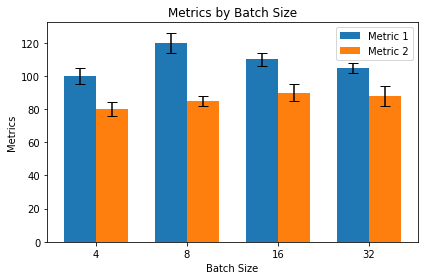

In [36]:
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
batch_sizes = [4, 8, 16, 32]  # Batch sizes
mem_mean = [100, 120, 110, 105]  # Mean memory usage for each batch size
mem_std = [5, 6, 4, 3]  # Standard deviation of memory usage for each batch size
cpu_mean = [80, 85, 90, 88]  # Mean CPU utilization for each batch size
cpu_std = [4, 3, 5, 6]  # Standard deviation of CPU utilization for each batch size

# Number of metrics (e.g., memory usage, CPU utilization)
num_metrics = 2

bar_width = 0.35  # Width of each bar
index = range(len(batch_sizes))  # Index for x-axis positions

# Plotting grouped bars for each metric
fig, ax = plt.subplots()
for i in range(num_metrics):
    bars = ax.bar([x + i * bar_width for x in index], [mem_mean, cpu_mean][i],
                  bar_width, yerr=[mem_std, cpu_std][i], capsize=5, label=f"Metric {i+1}")

# Customize plot labels, titles, legends, etc.
ax.set_xlabel('Batch Size')
ax.set_ylabel('Metrics')
ax.set_title('Metrics by Batch Size')
ax.set_xticks([x + bar_width * (num_metrics - 1) / 2 for x in index])
ax.set_xticklabels(batch_sizes)
ax.legend()

plt.tight_layout()
plt.show()


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (24).

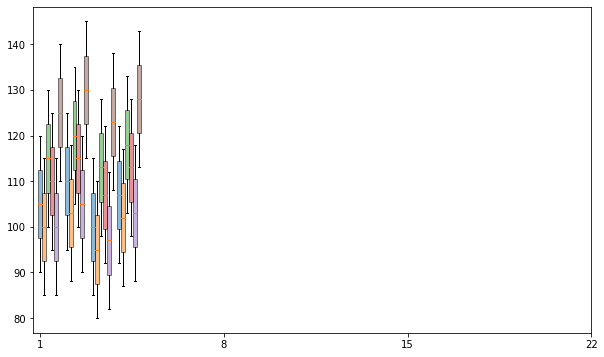

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace this with your actual data)
batch_sizes = [4, 8, 16, 32]  # Batch sizes
models = ['AlexNet', 'SqueezeNet', 'ResNet-18', 'ResNet-50', 'DenseNet', 'VGG16']  # Model names

# Example data for memory usage and CPU utilization (replace with your actual data)
mem_data = {
    'AlexNet': [[90, 100, 110, 120], [95, 105, 115, 125], [85, 95, 105, 115], [92, 102, 112, 122]],
    'SqueezeNet': [[85, 95, 105, 115], [88, 98, 108, 118], [80, 90, 100, 110], [87, 97, 107, 117]],
    'ResNet-18': [[100, 110, 120, 130], [105, 115, 125, 135], [98, 108, 118, 128], [103, 113, 123, 133]],
    'ResNet-50': [[95, 105, 115, 125], [100, 110, 120, 130], [92, 102, 112, 122], [98, 108, 118, 128]],
    'DenseNet': [[85, 95, 105, 115], [90, 100, 110, 120], [82, 92, 102, 112], [88, 98, 108, 118]],
    'VGG16': [[110, 120, 130, 140], [115, 125, 135, 145], [108, 118, 128, 138], [113, 123, 133, 143]],
}

cpu_data = {
    'AlexNet': [[70, 80, 90, 100], [75, 85, 95, 105], [65, 75, 85, 95], [72, 82, 92, 102]],
    'SqueezeNet': [[65, 75, 85, 95], [70, 80, 90, 100], [60, 70, 80, 90], [67, 77, 87, 97]],
    'ResNet-18': [[80, 90, 100, 110], [85, 95, 105, 115], [78, 88, 98, 108], [83, 93, 103, 113]],
    'ResNet-50': [[75, 85, 95, 105], [80, 90, 100, 110], [72, 82, 92, 102], [78, 88, 98, 108]],
    'DenseNet': [[60, 70, 80, 90], [65, 75, 85, 95], [58, 68, 78, 88], [63, 73, 83, 93]],
    'VGG16': [[90, 100, 110, 120], [95, 105, 115, 125], [88, 98, 108, 118], [93, 103, 113, 123]],
}


# Create box plots for memory usage
plt.figure(figsize=(10, 6))

for model in models:
    mem_values = mem_data[model]
    positions = [i + 1 + models.index(model) * 0.15 for i in range(len(batch_sizes))]
    plt.boxplot(mem_values, positions=positions, widths=0.15, patch_artist=True, showfliers=False,
                boxprops=dict(facecolor=f'C{models.index(model)}', alpha=0.5), manage_ticks=False)

# Set x-axis ticks and labels
plt.xticks(np.arange(1, len(batch_sizes) * (len(models) + 1), len(models) + 1), batch_sizes * len(models))
plt.xlabel('Batch Size')
plt.ylabel('Memory Usage')
plt.title('Memory Usage by Batch Size for Different Models')

# Create legend for models
plt.legend(models)

plt.tight_layout()
plt.show()


In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Example data (replace this with your actual data)
batch_sizes = [4, 8, 16, 32]  # Batch sizes
mem_mean = [100, 120, 110, 105]  # Mean memory usage for each batch size
mem_std = [5, 6, 4, 3]  # Standard deviation of memory usage for each batch size
cpu_mean = [80, 85, 90, 88]  # Mean CPU utilization for each batch size
cpu_std = [4, 3, 5, 6]  # Standard deviation of CPU utilization for each batch size

# Create traces for memory and CPU metrics with error bars
trace_mem = go.Bar(
    x=batch_sizes,
    y=mem_mean,
    name='Memory Usage',
    error_y=dict(type='data', array=mem_std, visible=True),
    width=0.3,
    offset=-0.15
)

trace_cpu = go.Bar(
    x=batch_sizes,
    y=cpu_mean,
    name='CPU Utilization',
    error_y=dict(type='data', array=cpu_std, visible=True),
    width=0.3,
    offset=0.15
)

fig = make_subplots(rows=1, cols=1)

fig.add_trace(trace_mem)
fig.add_trace(trace_cpu)

fig.update_layout(
    title='Metrics by Batch Size',
    xaxis=dict(title='Batch Size'),
    yaxis=dict(title='Metrics'),
    barmode='group',
    legend=dict(x=1.1, y=1.0)
)

fig.show()


In [44]:
import pandas as pd

# Sample DataFrame
data = {
    'batch_size': [32, 32, 64, 64, 128, 128],
    'model_name': ['Model A', 'Model A', 'Model B', 'Model B', 'Model C', 'Model C'],
    'used': [100, 120, 80, 90, 150, 140]
}

mem_df = pd.DataFrame(data)

# Grouping by 'batch_size' and 'model_name' and calculating mean and std
mem_used = mem_df.groupby(["batch_size", "model_name"])["used"].agg(['mean', 'std']).reset_index()
mem_used = mem_used.rename(columns={"mean": "used_mean", "std": "used_std"})

print(mem_used)


   batch_size model_name  used_mean   used_std
0          32    Model A      110.0  14.142136
1          64    Model B       85.0   7.071068
2         128    Model C      145.0   7.071068
